In [1]:
!pip install super-gradients==3.1
!pip install prettyformatter 
!pip install onnx-simplifier 
!pip install infery gwpy 


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement infery (from versions: none)
ERROR: No matching distribution found for infery

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
images = os.listdir('Images/')
s=""
full_images_path=[]
for m in images:
    s="Images/" + m
    full_images_path.append(s)
full_images_path


['Images/Vehicle972_jpg.rf.18568c262b3e5c817b201085ddebbd0d.jpg',
 'Images/Vehicle976_jpg.rf.ae3f6d1b2bb4d50bb806963b437a0fce.jpg',
 'Images/Vehicle976_jpg.rf.cd7521c4bf5ff467d9cb8a8f3c5fb614.jpg',
 'Images/Vehicle978_jpg.rf.09d66de096677e7883cf7e51319f3af8.jpg',
 'Images/Vehicle97_jpg.rf.f90f80278a7d051770cba6df82aa1ca4.jpg',
 'Images/Vehicle981_jpg.rf.954fab10a0e8f497d321582c9da2a9d3.jpg',
 'Images/Vehicle982_jpg.rf.b977ea9ec920b4930a699da142ec7015.jpg',
 'Images/Vehicle983_jpg.rf.158d4b78db80e2663b5db8d9937c890d.jpg',
 'Images/Vehicle9_jpg.rf.07e5f5492b72101d235c774e79a4f4f3.jpg',
 'Images/Vehicle9_jpg.rf.318302df6f20cde8ba9aefbd666c813e.jpg']

In [3]:
masks=os.listdir('binary_masks/')
s=""
full_mask_path=[]
for m in masks:
    s="binary_masks/" + m
    full_mask_path.append(s)
full_mask_path

['binary_masks/00000.png',
 'binary_masks/00001.png',
 'binary_masks/00002.png',
 'binary_masks/00003.png',
 'binary_masks/00004.png',
 'binary_masks/00005.png',
 'binary_masks/00006.png',
 'binary_masks/00007.png',
 'binary_masks/00008.png',
 'binary_masks/00009.png']

In [4]:
import pandas as pd
df=pd.DataFrame.from_dict({"images":full_images_path,"masks":full_mask_path})
df

,images,masks
0,Images/Vehicle972_jpg.rf.18568c262b3e5c817b201...,binary_masks/00000.png
1,Images/Vehicle976_jpg.rf.ae3f6d1b2bb4d50bb8069...,binary_masks/00001.png
2,Images/Vehicle976_jpg.rf.cd7521c4bf5ff467d9cb8...,binary_masks/00002.png
3,Images/Vehicle978_jpg.rf.09d66de096677e7883cf7...,binary_masks/00003.png
4,Images/Vehicle97_jpg.rf.f90f80278a7d051770cba6...,binary_masks/00004.png
5,Images/Vehicle981_jpg.rf.954fab10a0e8f497d3215...,binary_masks/00005.png
6,Images/Vehicle982_jpg.rf.b977ea9ec920b4930a699...,binary_masks/00006.png
7,Images/Vehicle983_jpg.rf.158d4b78db80e2663b5db...,binary_masks/00007.png
8,Images/Vehicle9_jpg.rf.07e5f5492b72101d235c774...,binary_masks/00008.png
9,Images/Vehicle9_jpg.rf.318302df6f20cde8ba9aefb...,binary_masks/00009.png


In [13]:
df.to_csv('train.csv')

In [2]:
from super_gradients.training import Trainer, MultiGPUMode

CHECKPOINT_DIR = '/notebook_ckpts/'
trainer = Trainer(experiment_name="segmentation_quick_start", ckpt_root_dir=CHECKPOINT_DIR)# multi_gpu=MultiGPUMode.OFF)

In [6]:
from super_gradients.training import models
import os

In [127]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
import numpy as np
from PIL import Image

class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        """
        self.data_folder = data_folder
        self.split = split.lower()
        assert self.split in {'train', 'val'}

        # Read data files
        with open(os.path.join(data_folder, self.split + '.csv'), 'r') as f:
            data_lines = f.readlines()
        self.samples_fn = [line.strip().split(",") for line in data_lines]
        
        self.transforms = transforms.Compose([transforms.ToTensor(),transforms.Resize((256,256))])

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.samples_fn[i][0]).convert('RGB')
        label = Image.open(self.samples_fn[i][1])
        label=self.transforms(label)
        label=torch.squeeze(label)
        
        image_tensor = self.transforms(image)
        label_tensor = torch.from_numpy(np.array(label))#.long()
    
        return image_tensor, label_tensor
        

    def __len__(self):
        return len(self.samples_fn)


In [128]:
train_dataset = CustomDataset("Data", split="train")
val_dataset = CustomDataset("Data", split="train")

In [129]:
img, lbl = train_dataset[0]
print(img.shape, lbl.shape)
print(torch.unique(lbl))
print("Val")
img, lbl = val_dataset[0]
print(img.shape, lbl.shape)
print(torch.unique(lbl))

torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor([0.0000, 0.2500, 0.4375, 0.7500, 0.8125, 0.9375, 1.0000])
Val
torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor([0.0000, 0.2500, 0.4375, 0.7500, 0.8125, 0.9375, 1.0000])


In [130]:
from torch.utils.data import Dataset, DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [131]:
next(iter(train_dataloader))[0].shape

torch.Size([4, 3, 256, 256])

In [132]:
next(iter(val_dataloader))[0].shape

torch.Size([4, 3, 256, 256])

In [133]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=1,
                   pretrained_weights="cityscapes")

In [134]:
from super_gradients.training.metrics.segmentation_metrics import IoU
from super_gradients.training.utils.callbacks import BinarySegmentationVisualizationCallback, Phase


train_params = {"max_epochs": 25,
                "lr_mode": "cosine",
                "initial_lr": 0.005,
                "optimizer": "SGD",
                "loss": "cross_entropy",
                "average_best_models": False,
                "metric_to_watch": "IoU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [IoU(num_classes=2)],
                "valid_metrics_list": [IoU(num_classes=2)],
                "loss_logging_items_names": ["loss"],
                "phase_callbacks": [BinarySegmentationVisualizationCallback(phase=Phase.VALIDATION_BATCH_END,
                                                                            freq=1,
                                                                            last_img_idx_in_batch=4)],

                }

In [135]:
%load_ext tensorboard
%tensorboard --logdir $CHECKPOINT_DIR --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [136]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-05-29 11:34:59] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-05-29 11:34:59] WARNING - callbacks.py - Parameter linear_step has been made deprecated and will be removed in the next SG release. Please use `linear_epoch_step` instead.


The console stream is now moved to /notebook_ckpts/segmentation_quick_start/console_May29_11_34_59.txt


[2023-05-29 11:35:00] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Dataset size:                 10         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         3          (len(train_loader))
    - Gradient updates per epoch:   3          (len(train_loader) / batch_accumulate)

[2023-05-29 11:35:00] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validation epoch 0: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Iou = 0.4929
│   └── Labelsmoothingcrossentropyloss = 21.5552
└── Validation
    ├── Iou = 0.4929
    └── Labelsmoothingcrossentropyloss = 22.5973



[2023-05-29 11:35:03] INFO - base_sg_logger.py - Checkpoint saved in /notebook_ckpts/segmentation_quick_start\ckpt_best.pth
[2023-05-29 11:35:03] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.4929054379463196
Train epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 23.9099
│       ├── Best until now = 21.5552 (↗ 2.3547)
│       └── Epoch N-1      = 21.5552 (↗ 2.3547)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 51.2429
        ├── Best until now = 22.5973 (↗ 28.6456)
        └── Epoch N-1      = 22.5973 (↗ 28.6456)



Validation epoch 2:  67%|██████▋   | 2/3 [00:00<00:00,  3.92it/s]

SUMMARY OF EPOCH 2
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 27.8948
│       ├── Best until now = 21.5552 (↗ 6.3396)
│       └── Epoch N-1      = 23.9099 (↗ 3.9849)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 26.0125
        ├── Best until now = 22.5973 (↗ 3.4152)
        └── Epoch N-1      = 51.2429 (↘ -25.2304)



Train epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 3
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 23.4878
│       ├── Best until now = 21.5552 (↗ 1.9326)
│       └── Epoch N-1      = 27.8948 (↘ -4.407)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 256.0055
        ├── Best until now = 22.5973 (↗ 233.4082)
        └── Epoch N-1      = 26.0125 (↗ 229.993)



Train epoch 5:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 4
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 28.3957
│       ├── Best until now = 21.5552 (↗ 6.8404)
│       └── Epoch N-1      = 23.4878 (↗ 4.9078)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 448617.84
        ├── Best until now = 22.5973 (↗ 448595.25)
        └── Epoch N-1      = 256.0055 (↗ 448361.84)



Train epoch 6:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 5
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 20.1006
│       ├── Best until now = 21.5552 (↘ -1.4546)
│       └── Epoch N-1      = 28.3957 (↘ -8.295)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 622561.5
        ├── Best until now = 22.5973 (↗ 622538.9)
        └── Epoch N-1      = 448617.84 (↗ 173943.66)



Train epoch 7:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 6
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 21.5471
│       ├── Best until now = 20.1006 (↗ 1.4465)
│       └── Epoch N-1      = 20.1006 (↗ 1.4465)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 378741.9
        ├── Best until now = 22.5973 (↗ 378719.3)
        └── Epoch N-1      = 622561.5 (↘ -243819.6)



Train epoch 8:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 7
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 21.2807
│       ├── Best until now = 20.1006 (↗ 1.1801)
│       └── Epoch N-1      = 21.5471 (↘ -0.2664)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 121259.914
        ├── Best until now = 22.5973 (↗ 121237.33)
        └── Epoch N-1      = 378741.9 (↘ -257482.02)



Train epoch 9:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 8
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.1449
│       ├── Best until now = 20.1006 (↘ -0.9557)
│       └── Epoch N-1      = 21.2807 (↘ -2.1358)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 105573.02
        ├── Best until now = 22.5973 (↗ 105550.43)
        └── Epoch N-1      = 121259.914 (↘ -15686.892)



Train epoch 10:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 9
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 20.5101
│       ├── Best until now = 19.1449 (↗ 1.3652)
│       └── Epoch N-1      = 19.1449 (↗ 1.3652)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 8733.893
        ├── Best until now = 22.5973 (↗ 8711.295)
        └── Epoch N-1      = 105573.02 (↘ -96839.13)



Train epoch 11:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 10
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.4563
│       ├── Best until now = 19.1449 (↗ 0.3114)
│       └── Epoch N-1      = 20.5101 (↘ -1.0538)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 870.7609
        ├── Best until now = 22.5973 (↗ 848.1636)
        └── Epoch N-1      = 8733.893 (↘ -7863.132)



Train epoch 12:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 11
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.9485
│       ├── Best until now = 19.1449 (↗ 0.8036)
│       └── Epoch N-1      = 19.4563 (↗ 0.4922)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 230.7944
        ├── Best until now = 22.5973 (↗ 208.1971)
        └── Epoch N-1      = 870.7609 (↘ -639.9665)



Train epoch 13:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 12
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.6252
│       ├── Best until now = 19.1449 (↗ 0.4803)
│       └── Epoch N-1      = 19.9485 (↘ -0.3233)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 124.4293
        ├── Best until now = 22.5973 (↗ 101.832)
        └── Epoch N-1      = 230.7944 (↘ -106.3652)



Train epoch 14:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 13
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.2237
│       ├── Best until now = 19.1449 (↗ 0.0788)
│       └── Epoch N-1      = 19.6252 (↘ -0.4014)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 88.1563
        ├── Best until now = 22.5973 (↗ 65.559)
        └── Epoch N-1      = 124.4293 (↘ -36.2729)



Train epoch 15:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 14
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.1347
│       ├── Best until now = 19.1449 (↘ -0.0102)
│       └── Epoch N-1      = 19.2237 (↘ -0.0891)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 55.4028
        ├── Best until now = 22.5973 (↗ 32.8055)
        └── Epoch N-1      = 88.1563 (↘ -32.7535)



Train epoch 16:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 15
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.9269
│       ├── Best until now = 19.1347 (↗ 0.7922)
│       └── Epoch N-1      = 19.1347 (↗ 0.7922)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 32.8515
        ├── Best until now = 22.5973 (↗ 10.2542)
        └── Epoch N-1      = 55.4028 (↘ -22.5513)



Train epoch 17:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 16
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 22.986
│       ├── Best until now = 19.1347 (↗ 3.8513)
│       └── Epoch N-1      = 19.9269 (↗ 3.0591)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 47.0846
        ├── Best until now = 22.5973 (↗ 24.4873)
        └── Epoch N-1      = 32.8515 (↗ 14.2331)



Train epoch 18:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 17
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.6483
│       ├── Best until now = 19.1347 (↗ 0.5137)
│       └── Epoch N-1      = 22.986 (↘ -3.3376)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 38.4423
        ├── Best until now = 22.5973 (↗ 15.845)
        └── Epoch N-1      = 47.0846 (↘ -8.6423)



Train epoch 19:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 18
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.1761
│       ├── Best until now = 19.1347 (↗ 0.0414)
│       └── Epoch N-1      = 19.6483 (↘ -0.4722)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 27.515
        ├── Best until now = 22.5973 (↗ 4.9177)
        └── Epoch N-1      = 38.4423 (↘ -10.9273)



Train epoch 20:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 19
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 18.6701
│       ├── Best until now = 19.1347 (↘ -0.4646)
│       └── Epoch N-1      = 19.1761 (↘ -0.506)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 20.4879
        ├── Best until now = 22.5973 (↘ -2.1094)
        └── Epoch N-1      = 27.515 (↘ -7.027)



Train epoch 21:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 20
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 20.57
│       ├── Best until now = 18.6701 (↗ 1.8999)
│       └── Epoch N-1      = 18.6701 (↗ 1.8999)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 19.6686
        ├── Best until now = 20.4879 (↘ -0.8193)
        └── Epoch N-1      = 20.4879 (↘ -0.8193)



Train epoch 22:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 21
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 19.4483
│       ├── Best until now = 18.6701 (↗ 0.7782)
│       └── Epoch N-1      = 20.57  (↘ -1.1218)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 19.2563
        ├── Best until now = 19.6686 (↘ -0.4123)
        └── Epoch N-1      = 19.6686 (↘ -0.4123)



Train epoch 23:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 22
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 18.8478
│       ├── Best until now = 18.6701 (↗ 0.1777)
│       └── Epoch N-1      = 19.4483 (↘ -0.6005)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 18.8146
        ├── Best until now = 19.2563 (↘ -0.4418)
        └── Epoch N-1      = 19.2563 (↘ -0.4418)



Train epoch 24:   0%|          | 0/3 [00:00<?, ?it/s]

SUMMARY OF EPOCH 23
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 18.8172
│       ├── Best until now = 18.6701 (↗ 0.1472)
│       └── Epoch N-1      = 18.8478 (↘ -0.0306)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 19.03
        ├── Best until now = 18.8146 (↗ 0.2155)
        └── Epoch N-1      = 18.8146 (↗ 0.2155)



Validation epoch 24:  67%|██████▋   | 2/3 [00:00<00:00,  3.81it/s]

Validation epoch 24: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]
[2023-05-29 11:35:48] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


SUMMARY OF EPOCH 24
├── Training
│   ├── Iou = 0.4929
│   │   ├── Best until now = 0.4929 (= 0.0)
│   │   └── Epoch N-1      = 0.4929 (= 0.0)
│   └── Labelsmoothingcrossentropyloss = 18.5885
│       ├── Best until now = 18.6701 (↘ -0.0815)
│       └── Epoch N-1      = 18.8172 (↘ -0.2287)
└── Validation
    ├── Iou = 0.4929
    │   ├── Best until now = 0.4929 (= 0.0)
    │   └── Epoch N-1      = 0.4929 (= 0.0)
    └── Labelsmoothingcrossentropyloss = 19.2271
        ├── Best until now = 18.8146 (↗ 0.4125)
        └── Epoch N-1      = 19.03  (↗ 0.197)



In [138]:
torch.save(model, "model.pth")

In [139]:
model = torch.load("model.pth")
model.eval()

PPLiteSegT(
  (encoder): PPLiteSegEncoder(
    (backbone): STDC1Backbone(
      (stages): ModuleDict(
        (block_s2): Sequential(
          (0): ConvBNReLU(
            (seq): Sequential(
              (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): ReLU()
            )
          )
        )
        (block_s4): Sequential(
          (0): ConvBNReLU(
            (seq): Sequential(
              (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): ReLU()
            )
          )
        )
        (block_s8): Sequential(
          (0): STDCBlock(
            (conv_list): ModuleList(
              (0): ConvBNReLU(
                (seq): Sequential(
                  (conv): Conv

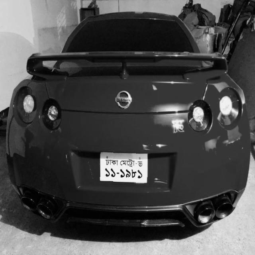

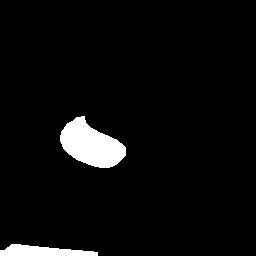

In [159]:
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, ToPILImage
from PIL import Image
import torch

pre_proccess = Compose([
    ToTensor(),
    Resize((256,256))
])

demo_img_path = "Data/images/train/Vehicle9_jpg.rf.07e5f5492b72101d235c774e79a4f4f3.jpg"
img = Image.open(demo_img_path)
img = Resize(size=(255, 255))(img)
display(img)


img = pre_proccess(img).unsqueeze(0)
mask = model(img)

 
mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = ToPILImage()(mask.float())
display(mask)
